In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_error

In [2]:
df = pd.read_csv("../DBtrainrides_complete_preprocessed_2.csv")

In [4]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../utils')))  # Add the parent directory to the path

from utils import fill_missing_times, normalize_dates, ordinal_scaling, custom_train_test_split

In [4]:
# df.to_csv("DBtrainrides_normalised.csv", index=False)

In [5]:
# df = pd.read_csv("DBtrainrides_normalised.csv")

In [5]:
X_train, y_train, X_test, y_test = custom_train_test_split(df, "arrival_delay_m", 0.8)

# Linear Regression

In [6]:
linear_regressor = LinearRegression()

In [7]:
linear_regressor.fit(X_train, y_train)
y_pred = linear_regressor.predict(X_test)

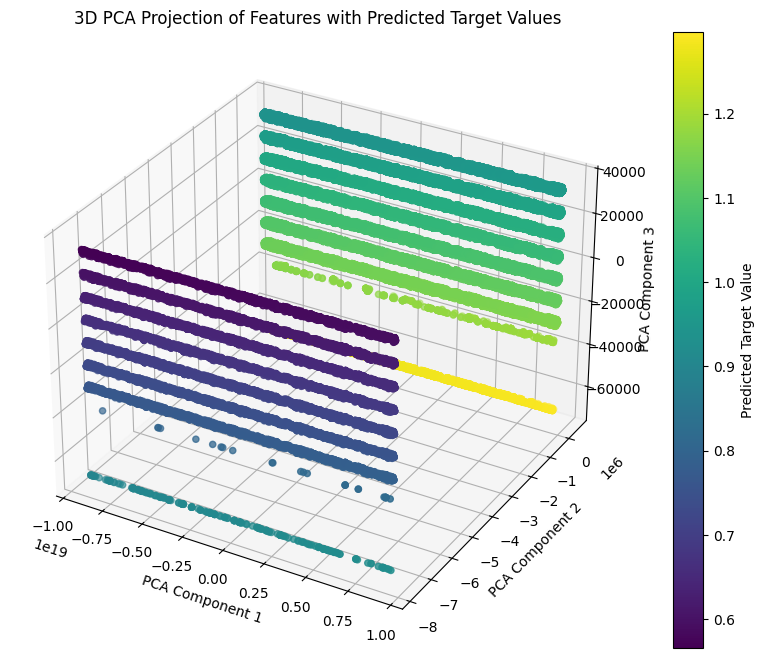

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# Apply PCA to reduce the dimensionality to 3 dimensions
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(X_test)

# Create a 3D scatter plot of the reduced features, colored by predicted target values
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=y_pred, cmap='viridis')
fig.colorbar(scatter, label='Predicted Target Value')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('3D PCA Projection of Features with Predicted Target Values')
plt.show()


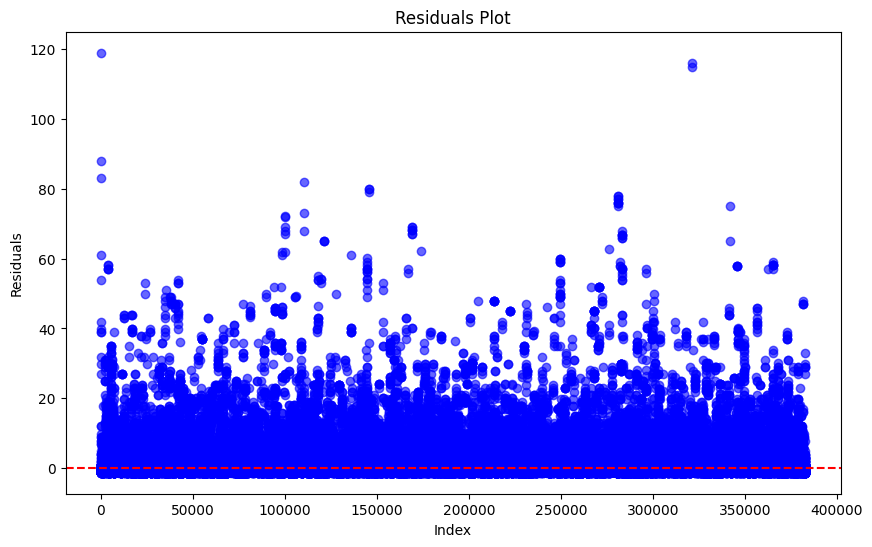

In [9]:
# Assuming you have actual target values (cleaned_target_test)
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, c='b', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [10]:
# Evaluate the model
mse = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mse)
print("R^2 Score:", r2)

Mean Absolute Error: 1.5094009208867059
R^2 Score: 0.0009534924513624476


Cross-Validation MAE: 1.4945 ± 0.0044


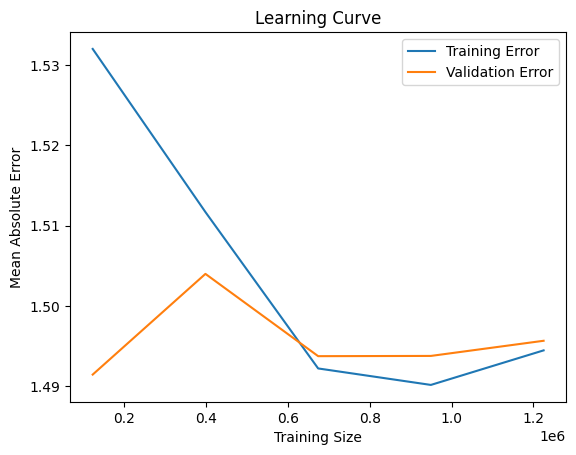

In [11]:
# Cross-validation with MAE
from sklearn.model_selection import KFold, learning_curve


kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(linear_regressor, X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
mean_cv_mae = -np.mean(cv_scores)
std_cv_mae = np.std(cv_scores)
print(f"Cross-Validation MAE: {mean_cv_mae:.4f} ± {std_cv_mae:.4f}")

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    linear_regressor, X_train, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1
)
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training Error")
plt.plot(train_sizes, test_scores_mean, label="Validation Error")
plt.xlabel("Training Size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [12]:
param_space = {'copy_X': [True,False], 
               'fit_intercept': [True,False], 
               'n_jobs': [1,5,10,15,None], 
               'positive': [True,False]}

In [13]:
grid_search_lr = GridSearchCV(linear_regressor, param_space, cv=5)
grid_search_lr.fit(X_train, y_train) 

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [1, 5, 10, 15, None],
                         'positive': [True, False]})

In [14]:
results = pd.DataFrame(grid_search_lr.cv_results_)
cv_params = results["params"]
cv_mean_test_score = results["mean_test_score"]
param_test_scores = []

In [15]:
for key in cv_params.keys():
    param = str(cv_params[key])
    score = float(cv_mean_test_score[key])
    target = (param, score)
    param_test_scores.append(target)

In [16]:
param_test_scores = sorted(param_test_scores, key=lambda x: x[1], reverse=True)

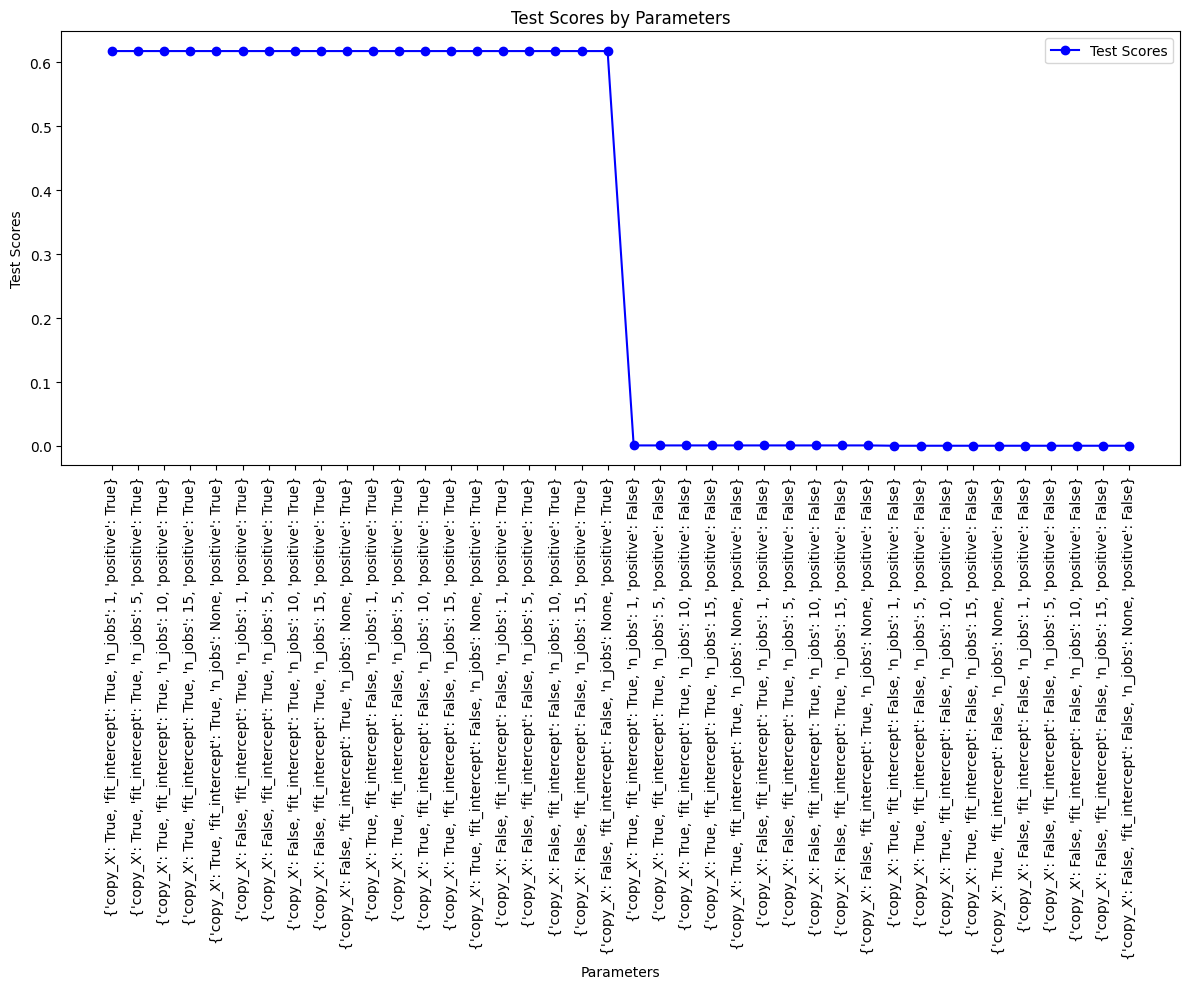

In [17]:
plt.figure(figsize=(12, 10))
plt.plot(
    [param for param, _ in param_test_scores],  # x-axis: parameters
    [score for _, score in param_test_scores],  # y-axis: test_scores
    marker='o', linestyle='-', color='b', label='Test Scores'
)

# Add labels and title
plt.xlabel('Parameters')
plt.ylabel('Test Scores')
plt.title('Test Scores by Parameters')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to fit rotated labels
plt.show()

In [18]:
linear_regressor = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, positive=True)
linear_regressor.fit(X_train, y_train)

LinearRegression(n_jobs=1, positive=True)

In [19]:
y_pred = linear_regressor.predict(X_test)
mae = mean_absolute_error(y_pred, y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Mean Absolute Error: 0.7380460578791739
R2 Score: 0.5890830588510816
